### Setup CD

In [1]:
%cd  /Users/natalipeeva/Documents/GitHub/Automatic-Answering-of-City-Council-Questions/

/Users/natalipeeva/Documents/GitHub/Automatic-Answering-of-City-Council-Questions


In [2]:
import sys
import os
src_dir = os.path.join(os.getcwd(), 'src_clean')
sys.path.append(src_dir)

In [3]:
import pandas as pd
from hashids import Hashids
from tabulate import tabulate

In [4]:
from src_clean.preprocessing.passages import create_passages_dataframe, add_passages_ids
from src_clean.preprocessing.text_preprocessing import preprocess_text
from src_clean.ranking.sparse_ranking import perform_tfidf_search, perform_random_search, perform_bm25_search
from src_clean.ranking.evaluation import calculate_average_metrics_retrieval, calculate_metrics_answer_similarity, simulate_answer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/natalipeeva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read Data

In [5]:
questions = pd.read_csv('data/question_answer/questions.csv')


In [6]:
len(questions)

19134

In [7]:
questions = pd.read_csv('data/question_answer/questions.csv')
collection = pd.read_csv('data/amsterdam/amsterdam_full.csv')

## Prepare Data for ranking

### Create passages

In [8]:
passages_df = create_passages_dataframe(collection) # 50 secs for execution
len(passages_df)

60902

### Clean passages

#### Drop duplicates in general; drop duplictates in column 'Textual_Content'

In [9]:
passages_df = passages_df.drop_duplicates() # drop dup.
len(passages_df)

56850

In [10]:
passages_df = passages_df.drop_duplicates(subset='Textual_Content', keep=False) # drop dup. passages
len(passages_df)

37177

#### Pre-process Passages Text

In [11]:
passages_df['Preprocessed_Text'] = passages_df['Textual_Content'].apply(lambda x: preprocess_text(x,stem=True,
                                                                                      remove_stopwords=True,
                                                                                      lowercase_text=True,
                                                                                      remove_punct=True)) # 40 seconds

#### Add Passage ids

In [12]:
hashids = Hashids()
passages_df["id"] = [hashids.encode(i) for i in range(len(passages_df))]

In [13]:
passages_df.tail()

,URL,Textual_Content,Preprocessed_Text,id
60888,https://www.amsterdam.nl/nrga/,Transponeringstabel Transponeringstabel ( PDF ...,transponeringstabel transponeringstabel pdf kb...,RrLE
60892,https://www.amsterdam.nl/nieuws/kennisgevingen...,Postcode Toelichting Vul een geldige postcode ...,postcod toelicht vul geldig postcod volgend fo...,VyNX
60893,https://www.amsterdam.nl/nieuws/kennisgevingen...,Verleend Pieter Calandlaan 339 05 juni 2023 Be...,verleend pieter calandlan juni besluit eveneme...,Wz8x
60894,https://www.amsterdam.nl/nieuws/kennisgevingen...,05 juni 2023 Besluit ( ) exploitatievergunning...,juni besluit exploitatievergunn horecabedrijf ...,XAMg
60895,https://www.amsterdam.nl/nieuws/kennisgevingen...,juni 2023 Besluit apv vergunning Verleend - Ou...,juni besluit apv vergunn verleend oudezijd voo...,YBM2


### Clean Questions

#### Pre-process questions and answers

In [14]:
questions.dropna(subset=['Question', 'Answer'], inplace=True)

In [15]:
len(questions)

19122

In [16]:
questions = questions.drop_duplicates()

In [17]:
len(questions)

19068

In [18]:
questions.drop_duplicates(subset='Answer', inplace=True)

In [19]:
len(questions)

18081

In [20]:
questions.drop_duplicates(subset='Question', inplace=True)

In [21]:
len(questions)

18037

In [22]:
questions.head()

,Year,Month,Question,Answer,Document,URLs
0,2018,12,\n \n1. Heeft het college kennisgenomen van de...,\nNee.,https://amsterdam.raadsinformatie.nl/document/...,NaN
1,2018,12,\n \n2. Kan het college bevestigen of dit lesm...,"\nNee, het college heeft hier geen zicht op. ...",https://amsterdam.raadsinformatie.nl/document/...,NaN
2,2018,12,\n \n ...,\nHet CIDI is duidelijk over de eigen doelste...,https://amsterdam.raadsinformatie.nl/document/...,NaN
3,2018,12,\n \n4. Is het college bekend met de jaarlijks...,\nHet college heeft hier kennis van genomen.,https://amsterdam.raadsinformatie.nl/document/...,NaN
4,2018,12,\n \na. Is het college van oordeel dat het CID...,vraag 4a: \nHet college is voor een pluriform...,https://amsterdam.raadsinformatie.nl/document/...,NaN


In [23]:
questions['Preprocessed_Question'] = questions['Question'].apply(lambda x: preprocess_text(x,stem=True,
                                                                                      remove_stopwords=True,
                                                                                      lowercase_text=True,
                                                                                      remove_punct=True)) 

questions['Preprocessed_Answer'] = questions['Answer'].apply(lambda x: preprocess_text(x,stem=True,
                                                                                      remove_stopwords=True,
                                                                                      lowercase_text=True,
                                                                                      remove_punct=True)) 

In [24]:
questions.drop_duplicates(subset='Preprocessed_Question', inplace=True)

In [25]:
questions.drop_duplicates(subset='Preprocessed_Answer', inplace=True)

In [26]:
len(questions)

17374

In [27]:
questions.describe()

,Year,Month,Question,Answer,Document,URLs,Preprocessed_Question,Preprocessed_Answer
count,17374,17374,17374,17374,17374,617,17374,17374
unique,10,12,17374,17374,2948,587,17374,17374
top,2020,8,\n \n1. Heeft het college kennisgenomen van de...,\nNee.,https://amsterdam.raadsinformatie.nl/document/...,https://www.rijksoverheid.nl/documenten/kamers...,colleg kennisgenom genoemd publicatie cidi,nee
freq,2620,1832,1,1,41,5,1,1


In [28]:
question_lengths = []
for q in questions['Preprocessed_Question']:
    question_lengths.append(len(q.split()))

In [29]:
import matplotlib.pyplot as plt

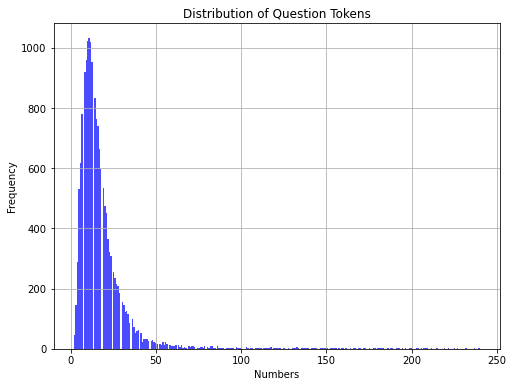

In [30]:
plt.figure(figsize=(8, 6))
plt.hist(question_lengths, bins='auto', color='blue', alpha=0.7)
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Question Tokens')
plt.grid(True)
plt.show()

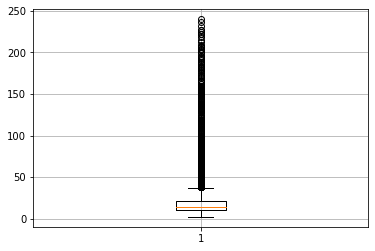

In [31]:
plt.boxplot(question_lengths)
plt.grid(True)
plt.show()

In [32]:
sum(question_lengths)/len(question_lengths)

18.039541844134913

In [33]:
answer_lengths = []
for q in questions['Preprocessed_Answer']:
    answer_lengths.append(len(q.split()))

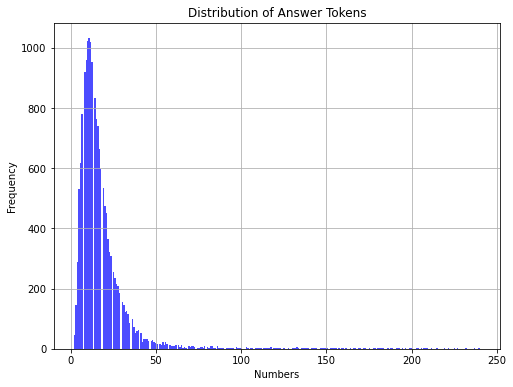

In [34]:
plt.figure(figsize=(8, 6))
plt.hist(question_lengths, bins='auto', color='blue', alpha=0.7)
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Answer Tokens')
plt.grid(True)
plt.show()

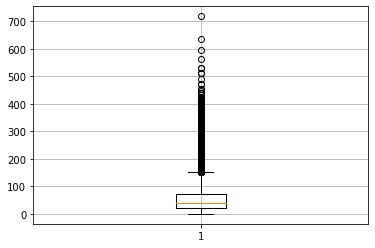

In [35]:
plt.boxplot(answer_lengths)
plt.grid(True)
plt.show()

In [36]:
sum(answer_lengths)/len(answer_lengths)

56.29826177046161

In [37]:
questions=questions[questions['Preprocessed_Answer'].str.split().str.len() > 10]

In [38]:
words_to_filter = ['bekend', 'kennisgenomen', 'op de hoogte', 'standpunt', 'mening', 'onbekend', 'vindt', 'visie',
                   'herkent']

In [39]:
questions = questions[~questions['Answer'].str.split().apply(lambda x: any(word.lower() in x for word in words_to_filter))]

In [40]:
questions = questions[~questions['Question'].str.split().apply(lambda x: any(word.lower() in x for word in words_to_filter))]

In [41]:
len(questions)

10971

In [42]:
questions=questions[questions['Preprocessed_Answer'].str.split().str.len() < 400]

In [43]:
#questions.head()

##### Add question ids 

In [44]:
hashids = Hashids()
questions["question_id"] = [hashids.encode(i) for i in range(len(questions))]

In [45]:
# questions.tail() # check

#### prepare dataset

In [46]:
from datasets import Dataset
import pyarrow as pa

In [47]:
arrow_table = pa.Table.from_pandas(questions)
arrow_dict = arrow_table.to_pydict()
questions = Dataset.from_dict(arrow_dict)

In [48]:
# questions[0] # check

In [49]:
arrow_table = pa.Table.from_pandas(passages_df)
arrow_dict = arrow_table.to_pydict()
passages_df = Dataset.from_dict(arrow_dict)

In [50]:
# passages_df[1000] # check

In [51]:
type(passages_df)

datasets.arrow_dataset.Dataset

## Ranking

### TF-IDF search

In [52]:
results_tfidf = perform_tfidf_search(questions, passages_df, k=100) # 6 mins for whole collection

### Random

In [57]:
import numpy as np

def random_search(query, collection, k, get_true_passages=False):
    if get_true_passages:
        true_documents = query['passages_ids']
    else:
        true_documents = []

    # Randomly select k documents from the collection
    collection_indices = np.arange(len(collection))
    random_indices = np.random.choice(collection_indices, size=k, replace=False)
    random_results = [collection[int(i)] for i in random_indices]

    ranked_ids = [result['id'] for result in random_results]
    ranked_text = [result['Textual_Content'] for result in random_results]
    ranked_preprocessed = [result['Preprocessed_Text'] for result in random_results]
    scores = []  # Assign random scores for demonstration purposes

    # Dictionary with search results
    search_results = {
        'question_id': query['question_id'],
        'question': query['Question'],
        'ranked_ids': ranked_ids,
        'ranked_text_preprocessed': ranked_preprocessed,
        'ranked_text': ranked_text,
        'true_passages': true_documents,
        'scores': scores,
        'answer': query['Answer'],
        'preprocessed_question': query['Preprocessed_Question'],
        'preprocessed_answer': query['Preprocessed_Answer']
    }

    return search_results


In [58]:
def perform_random_search(queries, collection, k, get_true_passages= False):
    """
    Perform random retrieval search for each query in a list of queries.
    Input:
        queries - a list of queries
        collection: a pandas DataFrame representing the collection
        k: the number of top search results to retrieve
    Output: a list of dictionaries containing the search results
    """
    search_results = []

    for query in queries:
        results = random_search(query, collection, k=k, get_true_passages=get_true_passages)
        search_results.append(results)

    return search_results

In [59]:
results_random = perform_random_search(questions, passages_df, k=100) # 18 secs

In [88]:
results_tfidf[6000]['question']

'\n \n3. De minister zegt de snorfietsen niet te kunnen verbieden. Is het mogelijk dat de \ngemeente Amsterdam het gebruik van snorfietsen kan verbieden in Amsterdam? \nZo nee, waarom niet?  \n \n'

In [89]:
results_tfidf[6000]['ranked_text'][:2]

['Milieuzone brom- en snorfietsen - Gemeente Amsterdam Direct naar inhoud GemeenteAmsterdam AAA Mijn Amsterdam English site Menuzoeken Onderwerpen Nieuws Contact Zoeken in Amsterdam.nl Zoek Zoek Verbergen Deze browser wordt niet meer ondersteund . Gebruik een recente versie van Edge , Chrome of Firefox . Pad tot huidige pagina Home Veelgevraagd Milieuzone brom- en snorfietsen In Amsterdam geldt een milieuzone voor brom- en snorfietsen . Hebt u een brommer , scooter of snorfiets met een Datum Eerste Toelating ( DET ) van 2010 of ouder , dan mag u niet meer in de bebouwde kom rijden . In sommige gevallen kunt',
 '? Brom- en snorfietsen met elektrische aandrijving Deze voertuigen zijn uitstootvrij en mogen vrij de milieuzone in . U hoeft geen ontheffing aan te vragen . Als een voertuig elektrisch is , dan staat dit bij de RDW geregistreerd . Brom- en snorfietsen met een DET vanaf 1 januari 2011 Het gaat om 2-takt en 4-takt brom- en snorfietsen met een DET vanaf 1 januari 2011 . U hoeft ge

In [90]:
results_random[6000]['ranked_text'][:2]

['Eekhoorns maken een speciaal kraamnest dat hoog in de boom , dicht tegen de stam gebouwd wordt . Het bestaat uit een vlechtwerk van takken , gevoerd met een dikke laag gras of ander zacht materiaal en heeft een doorsnede van ongeveer 40 centimeter . Soms worden holten in bomen of grote nestkasten gebruikt als nestplaats . Naast het grote nest zijn er ook 5 tot 6 reservenesten in de buurt . Het zogen duurt 10 weken . Dan verlaten de jongen het nest . Het duurt dan nog een paar weken voor ze volledig voor zichzelf kunnen zorgen .',
 'Prinsengracht 8 t/m 14 : maatregelen door slechte kademuur - Gemeente Amsterdam Direct naar inhoud GemeenteAmsterdam Mijn Amsterdam English site Menuzoeken Onderwerpen Nieuws Contact Zoeken in Amsterdam.nl Zoek Zoek Verbergen Deze browser wordt niet meer ondersteund . Gebruik een recente versie van Edge , Chrome of Firefox . Pad tot huidige pagina Home Bouwprojecten en verkeersprojecten Kademuren : maatregelen en vernieuwen Maatregelen en vernieuwen kademu

### BM25

In [ ]:
# results_bm25 = perform_bm25_search(questions_for_ranking, passages_df, k=100) # 1min 24

## Evaluation

#### Table

#### ROUGE Scores - Preprocessed ranked text and answer

#### Make Table

In [91]:
answers = list(questions['Preprocessed_Answer']) # preprocessed

In [92]:
results_lists = [results_tfidf, results_random]
retrieval_names = ['TF-IDF', 'Random']

simulated_answers = {}
metrics = {}

for results, retrieval_name in zip(results_lists, retrieval_names):
    simulated_answers[retrieval_name] = []
    metrics[retrieval_name] = {}
    
    for result in results: # generate simulated answers = get top retrieved documents till tokens are < 256
        simulated_answer = simulate_answer(result['ranked_text_preprocessed'])
        simulated_answers[retrieval_name].append(simulated_answer)
    
    metric_values = calculate_metrics_answer_similarity(simulated_answers[retrieval_name], answers) # get ROUGE 
    
    metrics[retrieval_name] = metric_values

# Print the metrics table
table = []
headers = ['Retrieval Method'] + list(metric_values.keys())

for retrieval_name in retrieval_names:
    row = [retrieval_name] + [metrics[retrieval_name][metric] for metric in metric_values.keys()]
    table.append(row)


KeyboardInterrupt: 

#### Table

In [ ]:
print(tabulate(table, headers=headers, tablefmt="grid"))

+--------------------+---------------------+---------------------+---------------------+--------------+------------+
| Retrieval Method   |   ROUGE-1 (Average) |   ROUGE-2 (Average) |   ROUGE-L (Average) |   BLEU Score |   F1 Score |
+====================+=====================+=====================+=====================+==============+============+
| TF-IDF             |           0.0967257 |          0.0136018  |           0.0571549 |  0.00204189  |          0 |
+--------------------+---------------------+---------------------+---------------------+--------------+------------+
| Random             |           0.0611094 |          0.00751903 |           0.0368162 |  0.000260963 |          0 |
+--------------------+---------------------+---------------------+---------------------+--------------+------------+
| BM25               |           0.095807  |          0.0102444  |           0.0535993 |  0.00191856  |          0 |
+--------------------+---------------------+--------------------

#### ROUGE Scores - Unpreprocessed ranked text and answer

#### Make table

In [ ]:
answers = list(questions_for_ranking['Answer']) # unpreprocessed

In [ ]:
results_lists = [results_tfidf, results_random, results_bm25]
retrieval_names = ['TF-IDF', 'Random', 'BM25']

simulated_answers = {}
metrics = {}

for results, retrieval_name in zip(results_lists, retrieval_names):
    simulated_answers[retrieval_name] = []
    metrics[retrieval_name] = {}
    
    for result in results: # generate simulated answers = get top retrieved documents till tokens are < 256
        simulated_answer = simulate_answer(result['ranked_text']) #unpreprocessed
        simulated_answers[retrieval_name].append(simulated_answer)
    
    metric_values = calculate_metrics_answer_similarity(simulated_answers[retrieval_name], answers) # get ROUGE 
    
    metrics[retrieval_name] = metric_values

# Print the metrics table
table = []
headers = ['Retrieval Method'] + list(metric_values.keys())

for retrieval_name in retrieval_names:
    row = [retrieval_name] + [metrics[retrieval_name][metric] for metric in metric_values.keys()]
    table.append(row)

#### Table

In [ ]:
print(tabulate(table, headers=headers, tablefmt="grid"))

+--------------------+---------------------+---------------------+---------------------+--------------+------------+
| Retrieval Method   |   ROUGE-1 (Average) |   ROUGE-2 (Average) |   ROUGE-L (Average) |   BLEU Score |   F1 Score |
+====================+=====================+=====================+=====================+==============+============+
| TF-IDF             |            0.216264 |           0.0303644 |            0.112037 |   0.00603454 |          0 |
+--------------------+---------------------+---------------------+---------------------+--------------+------------+
| Random             |            0.195447 |           0.0206645 |            0.102745 |   0.00145919 |          0 |
+--------------------+---------------------+---------------------+---------------------+--------------+------------+
| BM25               |            0.229851 |           0.0332365 |            0.122055 |   0.00798236 |          0 |
+--------------------+---------------------+--------------------

## Save ranked results

In [99]:
import os
import pickle

def save_results(results, question_collection, passages_collection, folder_path):
    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    
    # Get the variable names of question_collection and passages_collection
    question_var_name = [var_name for var_name, var_val in globals().items() if var_val is question_collection][0]
    passages_var_name = [var_name for var_name, var_val in globals().items() if var_val is passages_collection][0]

    # Save each result variable with its corresponding filename
    for result in results:
        # Get the variable name of the result variable
        result_var_name = [var_name for var_name, var_val in globals().items() if var_val is result][0]
        
        # Generate the filename based on variable names
        filename = '{}_{}_{}.pickle'.format(result_var_name, question_var_name, passages_var_name)
        
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'wb') as f:
            pickle.dump(result, f)


In [94]:
results = [results_tfidf, results_random]
question_collection = questions
passages_collection = passages_df
folder_path = 'data/results_ranking'

In [101]:
save_results(results, question_collection, passages_collection, folder_path)

In [102]:
import pickle
with open('data/results_ranking/questions_preprocessed.pickle', 'wb') as f:
    pickle.dump(questions, f)

with open('data/results_ranking/passages_preprocessed.pickle', 'wb') as f:
    pickle.dump(passages_df, f)

In [103]:
import pickle

with open('/Users/natalipeeva/Documents/GitHub/Automatic-Answering-of-City-Council-Questions/data/results_ranking/results_tfidf_questions_passages_df.pickle', 'rb') as f:
    test = pickle.load(f)

In [105]:
test[6000]['question']

'\n \n3. De minister zegt de snorfietsen niet te kunnen verbieden. Is het mogelijk dat de \ngemeente Amsterdam het gebruik van snorfietsen kan verbieden in Amsterdam? \nZo nee, waarom niet?  \n \n'

In [ ]:
test

In [107]:
test[6000]['ranked_text'][:2]

['Milieuzone brom- en snorfietsen - Gemeente Amsterdam Direct naar inhoud GemeenteAmsterdam AAA Mijn Amsterdam English site Menuzoeken Onderwerpen Nieuws Contact Zoeken in Amsterdam.nl Zoek Zoek Verbergen Deze browser wordt niet meer ondersteund . Gebruik een recente versie van Edge , Chrome of Firefox . Pad tot huidige pagina Home Veelgevraagd Milieuzone brom- en snorfietsen In Amsterdam geldt een milieuzone voor brom- en snorfietsen . Hebt u een brommer , scooter of snorfiets met een Datum Eerste Toelating ( DET ) van 2010 of ouder , dan mag u niet meer in de bebouwde kom rijden . In sommige gevallen kunt',
 '? Brom- en snorfietsen met elektrische aandrijving Deze voertuigen zijn uitstootvrij en mogen vrij de milieuzone in . U hoeft geen ontheffing aan te vragen . Als een voertuig elektrisch is , dan staat dit bij de RDW geregistreerd . Brom- en snorfietsen met een DET vanaf 1 januari 2011 Het gaat om 2-takt en 4-takt brom- en snorfietsen met een DET vanaf 1 januari 2011 . U hoeft ge

In [108]:
test[6000]['answer']

'  \nDe gemeente Amsterdam kan snorfietsen niet verbieden. De minister bedoelt dat \nsnorfietsen beschikken over een Europese typegoedkeuring. De Europese \nrichtlijn voor twee- of driewielige motorvoertuigen stelt dat: “De lidstaten mogen \nhet in de handel brengen, de verkoop, het in het verkeer brengen en het gebruik \nvan nieuwe voertuigen die aan deze richtlijn voldoen niet verbieden ". Binnen de \nverkeerswetgeving is het mogelijk snorfietsen te weren op bepaalde routes via \nverkeersborden (bijvoorbeeld met geslotenverklaringen). Dit gebeurt al in de \nonderdoorgang van het Rijksmuseum en in parken.  '